In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from os import listdir
from scipy.spatial.distance import pdist, squareform

rcParams = {'font.size': 24 , 'font.weight': 'bold', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal', 'lines.linewidth':3}


In [2]:
data_dir = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/\
Ref_Guided_Scaffolding_Clustering_Aug_2022/Read_Alignments_to_Novel_Contigs/Summarized_Coverages/'
files = listdir(data_dir)
df_Summary = pd.DataFrame()
for f in files:
    if f.startswith("Hot"):
        df = pd.read_csv(data_dir+f, sep = "\t")
        del df['Unnamed: 0']
        df_Summary = df_Summary.append(df, ignore_index = True)
        
df_breadth = df_Summary.pivot_table(index = 'Sample', columns = 'Subject',values = 'Breadth_Coverage')
df_breadth = df_breadth.fillna(0).reset_index()
df_breadth['Sample'] = df_breadth['Sample'].str.replace("_FD.paf","")
df_breadth = df_breadth.set_index('Sample')

df_depth = df_Summary.pivot_table(index = 'Sample', columns = 'Subject',values = 'Avg_Depth_Coverage')
df_depth = df_depth.fillna(0).reset_index()

df_reads = df_Summary.pivot_table(index = 'Sample', columns = 'Subject',values = 'Num_Reads')
df_reads = df_reads.fillna(0).reset_index()

/Users/harihara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]


In [3]:
FM = df_breadth.values#df.filter(regex = "Group_*").values
FM[FM < 95] = 0
FM[FM >= 95] = 1

df_Metadata = pd.read_csv('/Users/harihara/Research-Activities/Data/Hot-Spring/hotspring_metadata.csv', 
                          sep = ",", index_col = 'SampleID')
sample_spring = dict(zip(df_Metadata.index.tolist(), df_Metadata.Spring_Name.tolist()))
Dist_Mat = squareform(pdist(FM, metric = "hamming"))

/Users/harihara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys


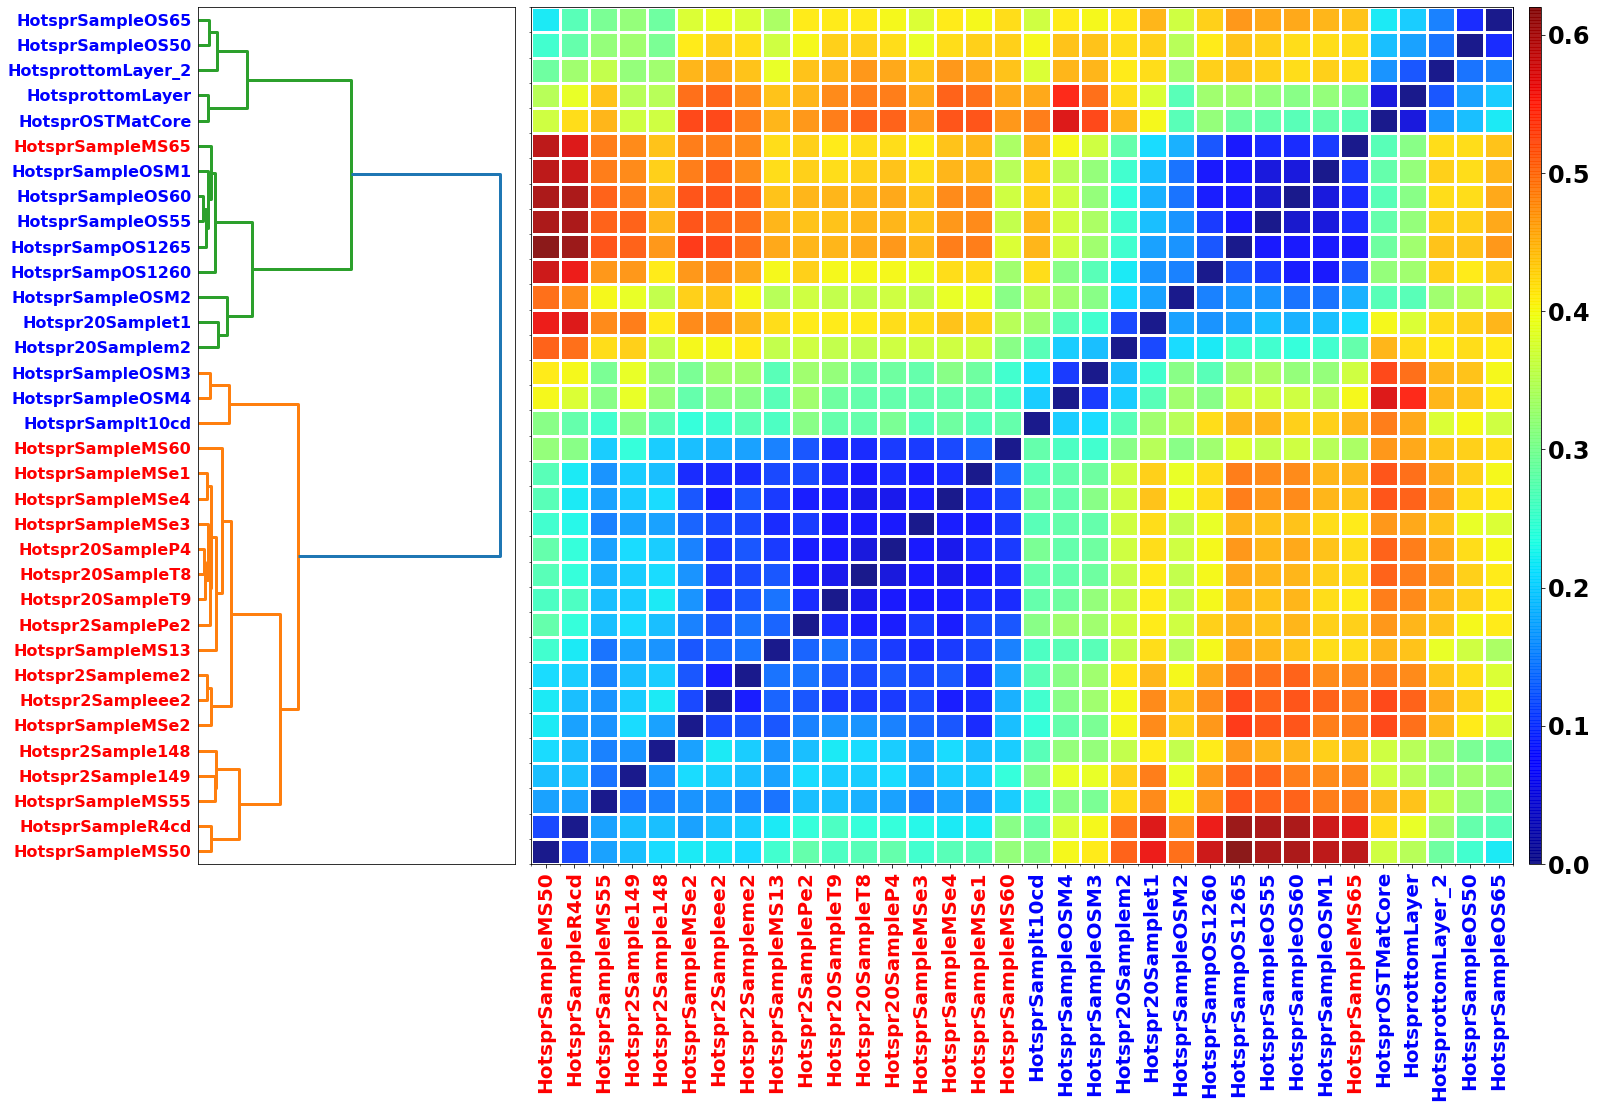

In [5]:
plt.rcParams.update(rcParams)

MAT = Dist_Mat

fig = plt.figure(figsize=(22,17))
axdendro = fig.add_axes([0.1,0.25,0.2,0.7])
Y = sch.linkage(MAT, method='ward',optimal_ordering=True)
Z = sch.dendrogram(Y, orientation='right', color_threshold = 0.8*max(Y[:,2]))
index = Z['leaves']
ticks = np.array(df_breadth.index.tolist())
axdendro.set_xticks([])
axdendro.set_yticklabels(ticks[index], size = 16)
a = [axdendro.get_yticklabels()[i].set_color('red')  
     if (sample_spring[ticks[index][i]] == 'Mushroom' ) 
     else axdendro.get_yticklabels()[i].set_color('blue') 
     for i in range(len(axdendro.get_yticklabels()))]

axmatrix = fig.add_axes([0.31,0.25,0.62,0.7])

MAT = MAT[index,:]
MAT = MAT[:,index]
MAT = np.round(MAT, 2)
#MAT[MAT == 0] = np.inf
im = axmatrix.imshow(MAT, aspect='auto', origin='lower', interpolation = 'none', cmap = 'jet', alpha = 0.9)
axmatrix.set_xticks(list(range(0, len(ticks))))
axmatrix.set_xticklabels(ticks[index], rotation = 90, size = 20)
axmatrix.xaxis.set_ticks_position('bottom')
ng = len(ticks)
axmatrix.set_xticks(np.arange(-.5, 34, 1), minor=True)
axmatrix.set_yticks(np.arange(-.5, 34, 1), minor=True)
a = [axmatrix.get_xticklabels()[i].set_color('red')  
     if (sample_spring[ticks[index][i]] == 'Mushroom' ) 
     else axmatrix.get_xticklabels()[i].set_color('blue') 
     for i in range(len(axmatrix.get_xticklabels()))]

# Gridlines based on minor ticks
axmatrix.grid(which='minor', color='white', linestyle='-', linewidth=3)

axmatrix.set_yticks([])

axcolor = fig.add_axes([0.94,0.25,0.0075,0.7])
plt.colorbar(im, cax=axcolor)

fig.subplots_adjust(bottom = 0.001, left = 0.01)
fig.savefig('/Users/harihara/Research-Activities/Plots/Hot_Spring_Plots/Synechococcus-Paper/\
Cluster_Novel_Contigs(Reads).pdf')